# Unsupervised Learning

**THIS IS ONLY FOR 15-688 STUDENTS**

You cannot use the scikit-learn package. You are free to use anything else.

In this question, you will explore various unsupervised learning techniques in the context of facial recognition. We've prefetched and processed a dataset of faces from Faces in the Wild, which is a collection of recognized pictures of faces (http://vis-www.cs.umass.edu/lfw/). We have cropped, resized, and turned a subset of the images into black and white images for this assignment. 

The faces are stored in `faces_all.txt.gz` as an array of integers indicating the grayscale on a 256 scale. The names of the person in each photo is in `labels_all.txt.gz`. 

Debugging tips: To ensure your algorithm has the correct behavior, we suggest the following baseline test (since debugging on high dimensional data is significantly harder and more time consuming): 
1. Use `np.random.mulivariate_normal` to samples from 2+ multivariate gaussians in 2D space (for easy visualization)
2. Ensure that your clustering algorithm is able to correctly cluster the gaussians you sampled from. 

In [32]:
import gzip
import itertools
import math
import os
from collections import Counter

import numpy as np
import scipy.sparse as sp
import matplotlib
matplotlib.use("svg")
if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from testing.testing import test

D:\python1\lib\site-packages\ipykernel_launcher.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\python1\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\python1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\python1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\python1\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\python1\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\python1\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop

Here we provide a wrapper function to cache the loaded dataset. This helps it not take quite as long to re-run. 

In [33]:
global DATA_CACHE
DATA_CACHE = None

def get_data():
    global DATA_CACHE
    if DATA_CACHE is None:
        with gzip.open('faces_all.txt.gz', 'rt') as f:
            data = np.loadtxt(f)
        with gzip.open('labels_all.txt.gz') as f:
            labels = [line.rstrip() for line in f]
        DATA_CACHE = (data, labels)
    return DATA_CACHE

## Image Visualization 

It will be extremely valuable to be able to visualize the images and cluster means. So first you should create the following function, which plots a matrix of images in a grid structure. Each row of your data matrix is a vector of pixel values ranging from 0 to 255, as a grayscale value. 

### Specification
* You can assume that the number of pixels is a square number
* Use the matplotlib subplots to form a grid of images, and use `imshow` to plot the image. 
* For grading purposes, you should return a list of `matplotlib.image.AxesImage` objects. This is simply the result of calling the matplotlib `imshow` function. 
* The order of the returned objects should match the order of the matplotlib subplots. 
* You can assume that there are at least rows\*cols entries in X. If there are more than that many, just plot the first rows\*cols entries. 

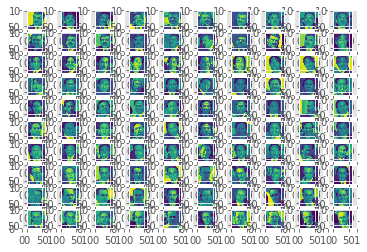

### TESTING plot_images: PASSED 4/4
###



In [34]:
def plot_images_test(plot_images_impl):
    data, labels = get_data()
    result = plot_images_impl(data, 10, 10)
    plt.show()

    test.true(np.all([isinstance(r, matplotlib.image.AxesImage) for r in result]))
    test.equal(len(result), 100)
    test.equal(result[0].get_array().data.shape, (60, 60))
    test.true(np.all(result[1].get_array().data.reshape(3600) == data[1, :]))

@test
def plot_images(data, rows, cols):
    """ Plots a matrix of images in a (row by col) grid
        Args: 
            data (numpy 2D matrix) : matrix of images, each row is an image
            rows (int) : number of rows to plot in a grid
            cols (int) : number of cols to plot in a grid
        Returns: 
            (list) : list of matplotlib.image.AxesImage objects
    """
    l=[]
    im=data[0:rows*cols]
    d=int(np.sqrt(data.shape[1]))
    ims=im.reshape(len(im), d, d)
    fig, axe = plt.subplots(rows, cols)
    
    for i, image in enumerate(ims):
        ax=fig.add_subplot(rows,cols,i+1)
        l.append(ax.imshow(image))
    return l
    
    pass

## K-means clustering (KMeans++)
The first task here is to implement k-means clustering, as seen on slides 12 and 23 of the unsupervised learning lecture. We will use this to attempt to cluster the images into something more meaningful. 


### Specification
* Use np.argmin when assigning clusters to get a consistent result with the grading script. 
* You can refer to the above visualization to write your plotting function
* You should initialize your centers by using the KMeans++ initialization described in the slides. This typically gives significantly better results. 

### TESTING kmeans: PASSED 8/8
###



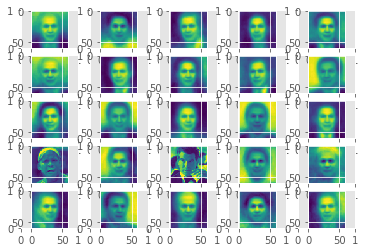

In [35]:
def kmeans_test(kmeans_impl):
    data, labels = get_data()
    KM = kmeans_impl()

    # Test init_centers
    centers = KM.init_centers(data, 25)
    test.equal(centers.shape[0], 25)

    # Test assign_clusters 
    centers_ = np.array([data[0, :], data[1, :], data[2, :]])
    y = KM.assign_clusters(data, centers_)
    test.equal(y.shape, (4324, 3))
    test.true(np.all(y[2] == np.array([0., 0., 1.])))
    test.true(np.all(y[5] == np.array([1., 0., 0.])))
    
    # Test compute_means
    centers_ = KM.compute_means(data, y)
    test.true(np.all(np.round(centers_[0][:10], 2) == np.array(
        [174.93, 176.69, 177.55, 178.32, 178.66, 178.46, 179.09, 179.5, 179.88, 179.61])))

    # Test train
    y_, centers_ = KM.train(data, centers_, 20)
    test.equal(np.sum(y != y_) / 2, 1196.0)
    test.true(np.all(y_[2] == np.array([0., 1., 0.])))
    test.true(np.all(y_[5] == np.array([0., 0., 1.])))
    
    # Plot centers
    y, centers = KM.train(data, centers, 20)
    plot_images(centers, 5, 5)


class KMeans:
    def init_centers(self, X, k):
        """ Initialize the starting k centers, using the KMeans++ algorithm. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                k (float) : number of clusters
            Return: 
                (numpy 2D matrix) : matrix of centers, each row is a center
        """
        rand_seed=0
        np.random.seed()
        Mu = X[np.random.choice(X.shape[0],k),:]
        return Mu
        pass
    
    def assign_clusters(self, X, centers):
        """ Given the data and the centers, assign clusters to all the examples. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                centers (numpy 2D matrix) : matrix of centers, each row is a center
            Return: 
                (numpy 2D matrix) : 1 hot encoding of cluster assignments for each example
        """
        D = -2*X@centers.T + (X**2).sum(axis=1)[:,None] + (centers**2).sum(axis=1)
        y = np.argmin(D,axis=1)
        b = np.zeros([len(y), len(set(y))])
        b[np.arange(len(y)), y] = 1
        return b
        pass
    
    def compute_means(self, X, y):
        """ Given the data and the cluster labels, compute the new cluster centers. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                y (numpy 2D matrix) : 1 hot encoding of cluster assignments for each example
            Return: 
                (numpy 2D matrix) : matrix of centers, each row is a center
        """
        Mu = np.array([np.mean(X[y[:, i]==1],axis=0) for i in range(y.shape[1])])
        return Mu
        pass
    
    def train(self, X, centers, niters=1):
        """ Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                centers (numpy 2D matrix) : initial matrix of centers, each row is a center
            Return: 
                (y, centers) : tuple of 1 hot encoding of cluster assignments for each example 
                               the resulting cluster centers
        """
        label = np.zeros(X.shape[0])
        for i in range(niters):
            label = self.assign_clusters(X, centers)
            centers = self.compute_means(X, label)
        
        return (label, centers)
        pass

    
@test
def kmeans():
    return KMeans()

## Cross-Entropy loss

One way to to measure the quality of your clusters (if we have labels for the true cluster) is to measure the purity of a cluster: if a cluster contains all of the same label, then it is a good cluster. One such measure is the cross entropy loss, which you've already seen when learning about decision trees (and in the MNIST homework if you were in 688). If $p_i$ is the proportion of cluster elements belonging to the true cluster $i$, then:

$$\text{CrossEntropyLoss(cluster)}=-\sum_{i\in \text{cluster}} p_i \log p_i$$

In other words, we take the proportions of all true clusters present in the estimated cluster, and calculate the cross entropy loss to see how good of a cluster it actually was. If everything in the cluster has the same label, then $p_i =1$ and so this sum is just 0, so 0 is a perfect score. The worst case is if the cluster is evenly distributed amongst $T$ clusters, and so $p_i = 1/T$ for $T$ clusters, resulting in a loss of $-\log 1/T$. 

### Specification
* Compute the cross entropy loss according to the above equation. 
* The sum should only be over true labels that are actually present in the cluster. 
* The total entropy is just the sum of the cross entropy loss of all the estimated clusters. 

In [36]:
def entropy_test(entropy_impl):
    data, labels = get_data()
    cluster_labels = labels[:172]
    loss = entropy_impl(cluster_labels)
    test.equal(np.round(loss, 3), 1.839)


@test
def entropy(cluster_labels):
    """ Calculate the entropy of a given cluster
        Args: 
            cluster_labels (list) : list of true cluster labels assigned to a cluster
        Return: 
            (float) : the cross entropy loss of this cluster
    """
    count = Counter(cluster_labels)
    prop = np.array(list(count.values()))/len(cluster_labels)
    entropy = -np.sum(prop*np.log(prop))
    return entropy
    pass

### TESTING entropy: PASSED 1/1
###



In [37]:
def total_entropy_test(total_entropy_impl):
    data, labels = get_data()
    
    # Split the dataset into 25 roughly even clusters
    y = np.zeros((len(labels), 25))
    size = int(math.ceil(float(len(labels))/25))
    for i in range(25):
        end = min((i+1)*size, len(labels))
        y[i*size: end, i] = 1
    loss = total_entropy_impl(y.astype(int), labels)
    test.equal(np.round(loss, 3), 39.558)

    y = np.zeros((len(labels), 25))
    size = int(math.ceil(float(len(labels))/25))
    P = np.random.permutation(data.shape[0])
    for i in range(25):
        end = min((i+1)*size, len(labels))
        indices = P[i*size: end]
        for idx in indices:
            y[idx, i] = 1
    loss_random = total_entropy_impl(y.astype(int), labels)

    # Get K-means clusters
    KM = KMeans()
    centers = KM.init_centers(data, 25)
    y, centers = KM.train(data, centers, 20)
    loss = total_entropy_impl(y, labels)

    # You should expect that the total entropy of the output of your K-means algorithm 
    # to do better than the total entropy of a random clustering.
    test.true(loss < loss_random)


@test
def total_entropy(y, labels):
    """ Compute the total cross entropy loss. 
        Args: 
            y (numpy 2D array) : one hot encoding of the estimated cluster labels
            labels (list) : list of the true labels of each data point
    """
    index = np.array([np.where(i==1)[0][0] for i in y])
    s=list(set(index))
    sum_entropy = 0
    for i in s:
        index1=np.where(index==i)
        label = [labels[i] for i in index1[0]] 
        sum_entropy = sum_entropy + entropy(label)
    return sum_entropy
    pass

### TESTING total_entropy: PASSED 2/2
###



## Gaussian Mixture Model

In this part, you will implement the softer cousin of K-means clustering: the Gaussian mixture model. For this problem, you should refer to the anomaly detection slides for the details of the algorithm. 

We have provided an implementation of the multivariate normal log PDF function that works on an array of samples. Note that scipy has one as well, but it can only calculate the log pdf for one example at a time and is not as efficient. 

### Specification
* Again, you can initialize your centers using the first k random indices from the permutation. 
* You should add a diagonal regularization to your covariance matrix to avoid singularity issues. 
* Your covariance matrix should be intialized as the sample covariance of the entire data matrix plus regularization using the unbiased estimater. You can use `np.cov` for this. 
* You can initialize  `phi` as a uniform discrete distribution over the clusters. 

In [38]:
def mv_normal_log_pdf(X, mu, Sig):
    return (-0.5*np.linalg.slogdet(2*np.pi*Sig)[1] - 0.5*np.sum((X-mu)*(np.linalg.inv(Sig).dot((X-mu).T)).T,axis=1))


def gaussian_mixture_test(gaussian_mixture_impl):
    data, labels = get_data()
    
    # Test init_parameters
    P = [i + j for i in range(100) for j in range(0, data.shape[0], 100) if i + j < data.shape[0]]
    GM = gaussian_mixture_impl()
    mus0, Sigmas0, phi0 = GM.init_parameters(data, P, 5, 1e-4)
    test.true(np.all(np.round(mus0[1, :10], 2) == np.array(
        [87.0, 83.0, 88.0, 95.0, 97.0, 93.0, 85.0, 81.0, 81.0, 84.0])))
    test.true(np.all(np.round(Sigmas0[1][0, :10], 2) == np.array(
        [5368.94, 5277.83, 5072.2, 4924.42, 4813.34, 4690.93, 4578.92, 4474.75, 4342.48, 4210.13])))
    test.equal(np.round(phi0[1], 4), 0.2)

    # Test Estep
    ps = GM.Estep(data, mus0, Sigmas0, phi0)
    test.true(np.all(np.round(ps[1, :], 2) == np.array([0.0, 0.0, 0.0, 0.0, 1.0])))
    
    # Test Mstep
    mus, Sigmas, phi = GM.Mstep(ps, data, 1e-4)
    test.true(np.all(np.round(mus[1, :10], 2) == np.array(
        [99.38, 99.35, 99.31, 99.98, 99.84, 100.13, 101.31, 102.03, 102.46, 103.53])))
    test.true(np.all(np.round(Sigmas[1][0, :10], 2) == np.array(
        [5642.57, 5392.95, 4964.43, 4820.24, 4665.81, 4439.01, 4283.85, 4210.54, 4095.74, 3855.13])))
    test.equal(np.round(phi[1], 4), 0.0542)

#     # Plot results with random permutation
#     P = np.random.permutation(data.shape[0])
#     GM = gaussian_mixture_impl()
#     mus0, Sigmas0, phi0 = GM.init_parameters(data, P, 5, 1e-4)
#     mus, Sigmas, phi = GM.train(data, mus0, Sigmas0, phi0, niters=10, reg=1e-4)
#     plot_images(mus, 1, 5)


class GaussianMixture:
    def init_parameters(self, X, P, k, reg):
        """ Initialize the parameters of means, covariances, and frequency counts. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                P (numpy 2D matrix) : Random permutation vector
                k (float) : number of clusters
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                mus (numpy 2D matrix) : matrix of initialized means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
        """
        
        mus = np.array([X[i] for i in P[:k]])
        r = np.eye(X.shape[1]) * reg
        Sigmas = [np.cov(X.T) + r for i in range(k)]
        phi = np.array([1/k for i in range(k)])

        return (mus, Sigmas, phi)

    def Estep(self, X, mus, Sigmas, phi):
        """ Perform an E step and return the resulting probabilities. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialized means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
            Returns: 
                (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                    ith element being in the jth cluster. 
        """
        
        p = np.zeros((X.shape[0],len(phi)))
        
        for i in range(len(phi)):
            p[:, i] = np.log(phi[i]) + mv_normal_log_pdf(X, mus[i], Sigmas[i])  
            

        for row in range(p.shape[0]):
            p[row] = p[row]-p[row].max()
        pr = np.exp(p)
        for row in range(pr.shape[0]):
            pr[row] /= np.sum(pr[row])
#         pr1 = pr/np.sum(pr)
        
#         prob = (p - (logsumexp(p,axis=1)[:,np.newaxis]))
#         pr = np.exp(prob)
#         print(pr)
        return pr
        pass

    def Mstep(self, ps, X, reg):
        """ Initialize the parameters of means, covariances, and frequency counts. 
            Args: 
                ps (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                       ith element being in the jth cluster. 
                X (numpy 2D matrix) : data matrix, each row is an example
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialized means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies
        """
        sig = []
        phi = np.sum(ps, axis=0)/X.shape[0]
        mus = ((ps.T.dot(X)).T/np.sum(ps, axis=0)).T
#         mus = np.zeros((ps.shape[1], X.shape[1]))
        sum_prob = np.sum(ps, axis=0)
        
        for i in range(ps.shape[1]):
#             mus[i] = np.sum(np.multiply(ps[:, i], X.T), axis=1)/sum_prob[i]
#             x1 = X-mus[i]
            sig.append((np.multiply(ps[:, i], (X-mus[i]).T) @ (X-mus[i]) + reg*np.eye(X.shape[1]))/sum_prob[i])
            
#         print(mus[1, :10])  
#         print(sig[1][0, :10])
#         print(phi[1])
        return (mus, sig, phi)
        pass
    
    def train(self, X, mus, Sigmas, phi, niters = 1, reg=1e-4):
        """ Train the model using the EM algorithm for a number of iterations. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialized means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
                niters (int) : number of EM iterations to run
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialized means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies 
        
        """
        for i in range(niters):
            ps = self.Estep(X, mus, Sigmas, phi)
            mus, Sigmas, phi = self.Mstep(ps, X, reg)
            
        return (mus, Sigmas, phi)
        pass
    

@test
def gaussian_mixture():
    return GaussianMixture()


### TESTING gaussian_mixture: PASSED 7/7
###



In [ ]:
[99.38, 99.35, 99.31, 99.98, 99.84, 100.13, 101.31, 102.03, 102.46, 103.53]
[5642.57, 5392.95, 4964.43, 4820.24, 4665.81, 4439.01, 4283.85, 4210.54, 4095.74, 3855.13]

The Gaussian mixture model takes a lot longer to train than the K-means model. You may also get better results initializing your clusters with the results from the K-means model. 